# Import main libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(7)

# Load dataset

In [2]:
df = pd.read_csv("~/clew/train_set.csv").drop(columns=['timestamp'])
df.head(10)

,temporary_index_column,patient_id,measurement_x,measurement_y,measurement_z,label
0,1,0,NaN,0.015569,0.068855,1
1,2,0,NaN,0.007757,0.073745,1
2,3,0,NaN,-0.000084,0.073402,1
3,4,0,NaN,-0.007953,0.075000,1
4,5,0,NaN,-0.015851,0.076689,1
5,6,0,0.798000,-0.023776,0.080064,1
6,7,0,0.795484,-0.031727,0.077065,1
7,8,0,0.793049,-0.039704,0.077875,1
8,9,0,0.790697,-0.047705,0.076800,1
9,10,0,0.788426,-0.055730,0.079076,1


# Define max sequence length

Found 97 different sequence sizes in training set


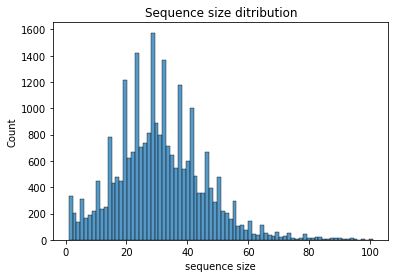

In [3]:
seq_sizes = df.groupby('patient_id').count().label
print(f'Found {len(seq_sizes.unique())} different sequence sizes in training set')

fit, ax = plt.subplots(1,1)
sns.histplot(seq_sizes, ax=ax)
ax.set_title("Sequence size ditribution")
ax.set_xlabel('sequence size')
plt.show()

In [4]:
max_seq_size = 60

# Rescaling the measurements to 0,1 using min-max scaler

In [6]:
scaler = MinMaxScaler()
measurements_label = ['measurement_x','measurement_y','measurement_z']
df[measurements_label] = scaler.fit_transform(df[measurements_label])

# Handling missing values

In [7]:
# handle missing values by replacing them with the value -1
df.fillna(-1, inplace=True)

df.head(10)

,temporary_index_column,patient_id,measurement_x,measurement_y,measurement_z,label
0,1,0,-1.000000,0.415782,0.151501,1
1,2,0,-1.000000,0.412720,0.161620,1
2,3,0,-1.000000,0.409647,0.160912,1
3,4,0,-1.000000,0.406562,0.164218,1
4,5,0,-1.000000,0.403466,0.167713,1
5,6,0,0.561678,0.400360,0.174698,1
6,7,0,0.560682,0.397244,0.168492,1
7,8,0,0.559718,0.394117,0.170168,1
8,9,0,0.558787,0.390981,0.167943,1
9,10,0,0.557889,0.387835,0.172653,1


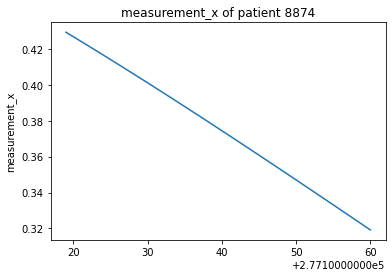

In [8]:
rand_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 0, 'patient_id'])]

sns.lineplot(data=rand_pat.measurement_x)
plt.title(f'measurement_x of patient {int(rand_pat.iloc[0].patient_id)}')
plt.show()

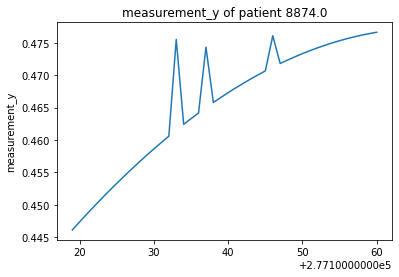

In [9]:
sns.lineplot(data=rand_pat.measurement_y)
plt.title(f'measurement_y of patient {rand_pat.iloc[0].patient_id}')
plt.show()

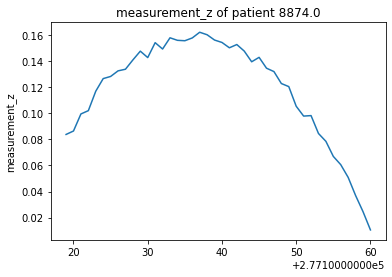

In [10]:
sns.lineplot(data=rand_pat.measurement_z)
plt.title(f'measurement_z of patient {rand_pat.iloc[0].patient_id}')
plt.show()

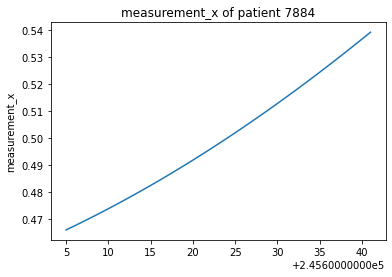

In [11]:
rand_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 1, 'patient_id'])]

sns.lineplot(data=rand_pat.measurement_x)
plt.title(f'measurement_x of patient {int(rand_pat.iloc[0].patient_id)}')
plt.show()

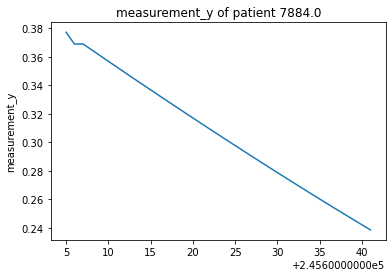

In [12]:
sns.lineplot(data=rand_pat.measurement_y)
plt.title(f'measurement_y of patient {rand_pat.iloc[0].patient_id}')
plt.show()

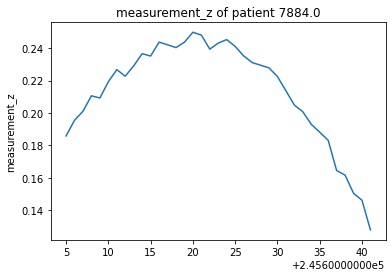

In [13]:
sns.lineplot(data=rand_pat.measurement_z)
plt.title(f'measurement_z of patient {rand_pat.iloc[0].patient_id}')
plt.show()

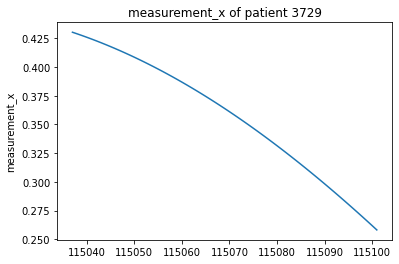

In [14]:
rand_pat = df[df.patient_id == np.random.choice(df.loc[df.label == 2, 'patient_id'])]

sns.lineplot(data=rand_pat.measurement_x)
plt.title(f'measurement_x of patient {int(rand_pat.iloc[0].patient_id)}')
plt.show()

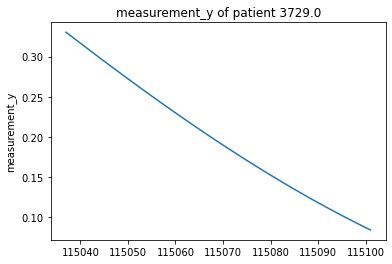

In [15]:
sns.lineplot(data=rand_pat.measurement_y)
plt.title(f'measurement_y of patient {rand_pat.iloc[0].patient_id}')
plt.show()

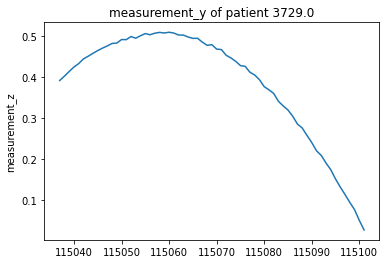

In [16]:
sns.lineplot(data=rand_pat.measurement_z)
plt.title(f'measurement_y of patient {rand_pat.iloc[0].patient_id}')
plt.show()

# Feature engineering and zero padding to each measurement

In [17]:
lst = []
for pat in df.patient_id.unique():
    temp_df = df[df.patient_id == pat][measurements_label].copy()
    temp_df = np.asarray(temp_df).reshape((1,) + temp_df.shape)
    n = temp_df.shape[1]
    if n < max_seq_size:
        completion = np.zeros(shape=(1,max_seq_size-n,3))
        temp_df = np.concatenate([completion, temp_df], axis=1)
    else:
        temp_df = temp_df[:,-max_seq_size:,:]
    
    lst.append(temp_df)
    
X = np.concatenate(lst, axis=0)

print("Example of a single record in new processed data:")
print(X[0])

Example of a single record in new processed data:
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         

# Oversample the data with SMOTE

In [18]:
label = df.drop_duplicates(subset='patient_id').label
label.value_counts()

0    17613
1     6214
2     1879
Name: label, dtype: int64

In [19]:
X = X.reshape(25706, 180)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, label)
X = X_res.reshape((len(X_res),max_seq_size,3))

label = y_res

# Train-Validation split

In [20]:
X_train, X_cv, y_train, y_cv = train_test_split(X, label, test_size=0.33, random_state=7)
print('train set size:', X_train.shape)
print('test set size:', X_cv.shape)

train set size: (35402, 60, 3)
test set size: (17437, 60, 3)


# Model Architecture - LSTM

In [94]:
model = Sequential()
model.add(LSTM(max_seq_size))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=3, batch_size=64)
print("\n")
print(model.summary())

Epoch 1/3
554/554 [==============================] - 20s 33ms/step - loss: 0.0000e+00 - precision_6: 0.7693 - recall_6: 0.4986 - val_loss: 0.0000e+00 - val_precision_6: 0.8783 - val_recall_6: 0.3591
Epoch 2/3
554/554 [==============================] - 17s 31ms/step - loss: 0.0000e+00 - precision_6: 0.7004 - recall_6: 0.7966 - val_loss: 0.0000e+00 - val_precision_6: 0.9273 - val_recall_6: 0.3749
Epoch 3/3
554/554 [==============================] - 19s 34ms/step - loss: 0.0000e+00 - precision_6: 0.8763 - recall_6: 0.4870 - val_loss: 0.0000e+00 - val_precision_6: 0.9275 - val_recall_6: 0.5310


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                15360     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 15,421
Trainable params: 15,421
Non

# Evaluation of the model

## Validation Metrics

In [95]:
loss, precision, recall = model.evaluate(X_cv, y_cv, verbose=0)
y_pred = model.predict(X_cv).reshape(-1).astype('int64').tolist()
y_true = y_cv.tolist()

print("\nValidation metrics:")
print({'loss': loss, 'precision': precision, 'recall': recall,
       'f1_score': 2*(precision*recall)/(precision + recall)})


Validation metrics:
{'loss': 0.0, 'precision': 0.9275274872779846, 'recall': 0.5309643149375916, 'f1_score': 0.6753332396112404}


## Classification matrix

In [96]:
print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.49      0.92      0.64      5843
           1       0.25      0.29      0.27      5784
           2       1.00      0.00      0.00      5810

    accuracy                           0.40     17437
   macro avg       0.58      0.40      0.30     17437
weighted avg       0.58      0.40      0.30     17437



In [65]:
test = pd.read_csv("~/clew/test_set.csv").drop(columns=['temporary_index_column','timestamp'])
test[measurements_label] = scaler.fit_transform(test[measurements_label])
test.fillna(-1, inplace=True)

lst = []
for pat in test.patient_id.unique():
    temp_df = test[test.patient_id == pat][measurements_label].copy()
    temp_df = np.asarray(temp_df).reshape((1,) + temp_df.shape)
    n = temp_df.shape[1]
    if n < max_seq_size:
        completion = np.zeros(shape=(1,max_seq_size-n,3))
        temp_df = np.concatenate([completion, temp_df], axis=1)
    else:
        temp_df = temp_df[:,-max_seq_size:,:]
    
    lst.append(temp_df)
    
X_test = np.concatenate(lst, axis=0)

In [97]:
y_pred = model.predict(X_test).reshape(-1).astype('int64')
patients = test.patient_id.drop_duplicates()
res = pd.DataFrame([y_pred, patients], index=["label","patient_id"]).T
res.to_csv('~/clew/submission.csv', index=False)
display(res.head(10))

,label,patient_id
0,0,25705
1,0,25706
2,0,25707
3,0,25708
4,0,25709
5,0,25710
6,0,25711
7,0,25712
8,0,25713
9,0,25714
